# Regression Analysis

HOPEFULLY THE RIGHT WAY

ADD TRAINING SCORES TO CV AREA

TRY POLYNOMIAL TRANSFORMATION???

SPLIT TRAIN/VAL AGAIN FOR LASSO/RIDGE??

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plb 
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

## Data Import & Setup

In [2]:
sf = pd.read_csv('data_files/sf_clean.csv')

# Reformatting hood_district names
sf['hood_district'] = sf['hood_district'].astype(int)
sf['hood_district'] = sf['hood_district'].astype(str)

Setting price threshold to $6,000

In [3]:
sf = sf[sf['price'] < 6000]

In [4]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 936 entries, 1 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          936 non-null    int64  
 1   sqft           936 non-null    float64
 2   beds           936 non-null    float64
 3   bath           936 non-null    float64
 4   laundry        936 non-null    object 
 5   pets           936 non-null    object 
 6   housing_type   936 non-null    object 
 7   parking        936 non-null    object 
 8   hood_district  936 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 73.1+ KB


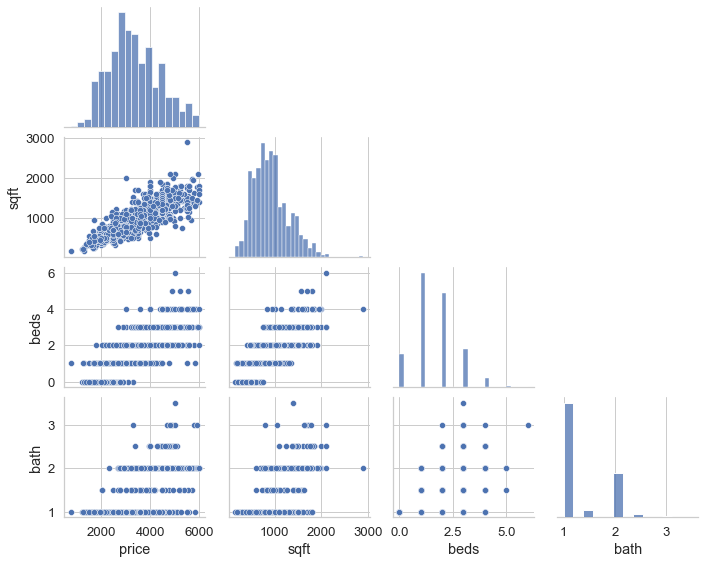

In [5]:
sns.pairplot(sf, height=2, aspect=1.25, corner=True);

### Categorical to Ordinal Features

In [6]:
laundry_dict = {'(a) in-unit': 2, 
               '(b) on-site': 1,
               '(c) no laundry': 0}

sf = sf.replace({'laundry': laundry_dict})

In [7]:
parking_dict = {'(a) valet': 3, 
               '(b) protected': 2,
               '(c) off-street': 1,
               '(d) no parking': 0}

sf = sf.replace({'parking': parking_dict})

In [8]:
pets_dict = {'(a) both': 1, 
            '(b) dogs': 1,
            '(c) cats': 1,
            '(d) no pets': 0}

sf = sf.replace({'pets': pets_dict})

### Dropping Features

In [9]:
#sf = sf.drop(['pets'], axis=1)
sf = sf.drop(['housing_type'], axis=1)

### Dummy Variables

In [10]:
sf = pd.get_dummies(sf)

In [11]:
cols_to_drop = [#'laundry_(c) no laundry',
               #'laundry_(b) on-site',
               #'pets_(d) no pets', 
               #'housing_type_(c) multi', 
               #'parking_(d) no parking',
               'hood_district_10']

sf = sf.drop(cols_to_drop, axis=1)

In [12]:
sf.head()

,price,sqft,beds,bath,laundry,pets,parking,hood_district_1,hood_district_2,hood_district_3,hood_district_4,hood_district_5,hood_district_6,hood_district_7,hood_district_8,hood_district_9
1,3500,550.0,1.0,1.0,2,1,2,0,0,0,0,0,0,1,0,0
2,5100,1300.0,2.0,1.0,2,1,0,0,0,0,0,0,0,1,0,0
4,3100,561.0,1.0,1.0,0,1,0,0,0,0,0,0,0,1,0,0
5,3800,800.0,2.0,1.0,1,1,2,0,0,0,0,0,0,0,0,1
6,3100,750.0,1.0,1.0,2,0,2,0,0,0,0,0,0,0,1,0


## Train / Test Split

In [13]:
X, y = sf.drop('price',axis=1), sf['price']

# Training versus Test Data
# hold out 30% of the data for testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=4)

In [14]:
# Scaling for Ridge & Lasso 
scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X.values)
X_test_scaled = scaler.transform(X_test.values)

## Linear Model

In [15]:
# restructuring X, y for kfolds
X_kf, y_kf = np.array(X), np.array(y)


kf = KFold(n_splits=5, shuffle=True, random_state = 3)
cv_lin_train_r2s = []
cv_lin_val_r2s = []
rmses_train, rmses_val = [], []

for train_ind, val_ind in kf.split(X_kf, y_kf):
    
    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    lin = LinearRegression()
    
    lin.fit(X_train, y_train)
    cv_lin_train_r2s.append(lin.score(X_train, y_train))
    cv_lin_val_r2s.append(lin.score(X_val, y_val))
    
    rmses_train.append(mean_squared_error(y_train, lin.predict(X_train), squared=False))
    rmses_val.append(mean_squared_error(y_val, lin.predict(X_val), squared=False))
    
    
print('Simple regression scores: ', cv_lin_val_r2s)
print("")
print(f'Simple mean cv r^2 (TRAIN): {np.mean(cv_lin_train_r2s):.3f} +- {np.std(cv_lin_train_r2s):.3f}')
print(f'Simple mean cv r^2 (VAL): {np.mean(cv_lin_val_r2s):.3f} +- {np.std(cv_lin_val_r2s):.3f}')
print("")
print(f'Simple mean RMSE (TRAIN): {np.mean(rmses_train):.3f} +- {np.std(rmses_train):.3f}')
print(f'Simple mean RMSE (VAL): {np.mean(rmses_val):.3f} +- {np.std(rmses_val):.3f}')

Simple regression scores:  [0.7266668412057561, 0.7281258784334679, 0.8065688271887491, 0.7858076157353225, 0.7563854509178062]

Simple mean cv r^2 (TRAIN): 0.773 +- 0.008
Simple mean cv r^2 (VAL): 0.761 +- 0.032

Simple mean RMSE (TRAIN): 487.077 +- 7.260
Simple mean RMSE (VAL): 497.243 +- 28.707


## Polynomial

In [16]:
# restructuring X, y for kfolds
X_kf, y_kf = np.array(X), np.array(y)


kf = KFold(n_splits=5, shuffle=True, random_state = 4)
cv_poly_train_r2s = []
cv_poly_val_r2s = []
rmses_train, rmses_val = [], []

for train_ind, val_ind in kf.split(X_kf, y_kf):
    
    # Feature setup
    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    poly = PolynomialFeatures(degree=2)
    
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Fit model
    lm_poly = LinearRegression()  
    lm_poly.fit(X_train_poly, y_train)
    
    # r^2 values
    cv_poly_train_r2s.append(lm_poly.score(X_train_poly, y_train))
    cv_poly_val_r2s.append(lm_poly.score(X_val_poly, y_val))
    
    # RMSE
    rmses_val.append(mean_squared_error(y_val, lm_poly.predict(X_val_poly), squared=False))
    rmses_train.append(mean_squared_error(y_train, lm_poly.predict(X_train_poly), squared=False))
    
print('Simple regression scores: ', cv_poly_val_r2s)
print("")
print(f'Poly mean cv r^2 (TRAIN): {np.mean(cv_poly_train_r2s):.3f} +- {np.std(cv_poly_train_r2s):.3f}')
print(f'Poly mean cv r^2 (VAL): {np.mean(cv_poly_val_r2s):.3f} +- {np.std(cv_poly_val_r2s):.3f}')
print("")
print(f'Poly mean RMSE (TRAIN): {np.mean(rmses_train):.3f} +- {np.std(rmses_train):.3f}')
print(f'Poly mean RMSE (VAL): {np.mean(rmses_val):.3f} +- {np.std(rmses_val):.3f}')

Simple regression scores:  [0.7728989336287199, 0.7646336913498133, 0.7381119374452265, 0.7056280711142351, 0.736471933264431]

Poly mean cv r^2 (TRAIN): 0.822 +- 0.006
Poly mean cv r^2 (VAL): 0.744 +- 0.024

Poly mean RMSE (TRAIN): 430.506 +- 6.941
Poly mean RMSE (VAL): 515.550 +- 24.284


## Lasso

In [17]:
alphavec = 10**np.linspace(-2,1,1000)

lasso_model = LassoCV(alphas=alphavec, cv=kf)
lasso_model.fit(X_train_scaled, y)

LassoCV(alphas=array([ 0.01      ,  0.01006939,  0.01013925,  0.01020961,  0.01028045,
        0.01035178,  0.01042361,  0.01049593,  0.01056876,  0.01064209,
        0.01071593,  0.01079029,  0.01086516,  0.01094055,  0.01101646,
        0.0110929 ,  0.01116987,  0.01124737,  0.01132541,  0.011404  ,
        0.01148312,  0.0115628 ,  0.01164303,  0.01172382,  0.01180517,
        0.01188708,  0.01196956,  0.01205261,  0.01213624,  0.01222045,
        0.012305...
        8.18300682,  8.23978568,  8.29695852,  8.35452806,  8.41249705,
        8.47086827,  8.5296445 ,  8.58882856,  8.64842328,  8.7084315 ,
        8.76885609,  8.82969996,  8.89096599,  8.95265713,  9.01477631,
        9.07732653,  9.14031075,  9.203732  ,  9.2675933 ,  9.33189772,
        9.39664831,  9.46184819,  9.52750047,  9.59360829,  9.6601748 ,
        9.72720319,  9.79469667,  9.86265846,  9.93109181, 10.        ]),
        cv=KFold(n_splits=5, random_state=4, shuffle=True))

In [18]:
las_alpha = lasso_model.alpha_
las_alpha

0.01

In [19]:
las = Lasso(alpha=las_alpha)

las.fit(X_train_scaled, y)
print(f'Lasso Regression train R^2: {las.score(X_train_scaled, y):.5f}')

Lasso Regression train R^2: 0.77169


## Ridge

In [20]:
alphavec = 10**np.linspace(-2,1,1000)

ridge_model = RidgeCV(alphas = alphavec, cv=kf)
ridge_model.fit(X_train_scaled, y)

RidgeCV(alphas=array([ 0.01      ,  0.01006939,  0.01013925,  0.01020961,  0.01028045,
        0.01035178,  0.01042361,  0.01049593,  0.01056876,  0.01064209,
        0.01071593,  0.01079029,  0.01086516,  0.01094055,  0.01101646,
        0.0110929 ,  0.01116987,  0.01124737,  0.01132541,  0.011404  ,
        0.01148312,  0.0115628 ,  0.01164303,  0.01172382,  0.01180517,
        0.01188708,  0.01196956,  0.01205261,  0.01213624,  0.01222045,
        0.012305...
        8.18300682,  8.23978568,  8.29695852,  8.35452806,  8.41249705,
        8.47086827,  8.5296445 ,  8.58882856,  8.64842328,  8.7084315 ,
        8.76885609,  8.82969996,  8.89096599,  8.95265713,  9.01477631,
        9.07732653,  9.14031075,  9.203732  ,  9.2675933 ,  9.33189772,
        9.39664831,  9.46184819,  9.52750047,  9.59360829,  9.6601748 ,
        9.72720319,  9.79469667,  9.86265846,  9.93109181, 10.        ]),
        cv=KFold(n_splits=5, random_state=4, shuffle=True))

In [21]:
rid_alpha = ridge_model.alpha_
rid_alpha

0.8183006815867394

In [22]:
rid = Ridge(alpha=rid_alpha)

rid.fit(X_train_scaled, y)
print(f'Ridge Regression train R^2: {rid.score(X_train_scaled, y):.5f}')

Ridge Regression train R^2: 0.77167


## Model Comparison

In [23]:
sf2 = sf.copy()

X, y = sf2.drop('price',axis=1), sf2['price']

# Training versus Test Data
# hold out 30% of the data for testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=25)

### R^2 and RMSE Evaluation

In [33]:
# restructuring X, y for kfolds
X_kf, y_kf = np.array(X), np.array(y)

kf = KFold(n_splits=3, shuffle=True, random_state = 3)

# r2s 
cv_lin_train_r2s, cv_poly_train_r2s, cv_rid_train_r2s, cv_las_train_r2s = [], [], [], []
cv_lin_val_r2s, cv_poly_val_r2s, cv_rid_val_r2s, cv_las_val_r2s = [], [], [], []

# RMSEs
lin_rmses_train, poly_rmses_train, rid_rmses_train, las_rmses_train = [], [], [], []
lin_rmses_val, poly_rmses_val, rid_rmses_val, las_rmses_val = [], [], [], []

# Cross Validation Workflow
for train_ind, val_ind in kf.split(X_kf, y_kf):
    
    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
       
    # Simple linear Regression
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    
    cv_lin_train_r2s.append(lin.score(X_train, y_train))
    cv_lin_val_r2s.append(lin.score(X_val, y_val))
    lin_rmses_train.append(mean_squared_error(y_train, lin.predict(X_train), squared=False))
    lin_rmses_val.append(mean_squared_error(y_val, lin.predict(X_val), squared=False))
    
    # Poly
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    lm_poly = LinearRegression()  
    lm_poly.fit(X_train_poly, y_train)
    
    cv_poly_train_r2s.append(lm_poly.score(X_train_poly, y_train))
    cv_poly_val_r2s.append(lm_poly.score(X_val_poly, y_val))  
    poly_rmses_train.append(mean_squared_error(y_train, lm_poly.predict(X_train_poly), squared=False))
    poly_rmses_val.append(mean_squared_error(y_val, lm_poly.predict(X_val_poly), squared=False))
    
    
    # Feature scaling for ridge & lasso
    scaler = StandardScaler(with_mean=False)
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    
    # Ridge
    rid = Ridge(alpha=rid_alpha)
    rid.fit(X_train_scaled, y_train)
    
    cv_rid_train_r2s.append(rid.score(X_train_scaled, y_train))
    cv_rid_val_r2s.append(rid.score(X_val_scaled, y_val))
    rid_rmses_train.append(mean_squared_error(y_train, rid.predict(X_train_scaled), squared=False))
    rid_rmses_val.append(mean_squared_error(y_val, rid.predict(X_val_scaled), squared=False))
    
    # Lasso
    las = Lasso(alpha=las_alpha)
    las.fit(X_train_scaled, y_train)
    
    cv_las_train_r2s.append(las.score(X_train_scaled, y_train))
    cv_las_val_r2s.append(las.score(X_val_scaled, y_val))
    las_rmses_train.append(mean_squared_error(y_train, las.predict(X_train_scaled), squared=False))
    las_rmses_val.append(mean_squared_error(y_val, las.predict(X_val_scaled), squared=False))
    

# Summary Output
print("Simple Linear Regression")
print('Simple regression scores (VAL): ', cv_lin_val_r2s)
print(f'Simple mean cv r^2 (TRAIN): {np.mean(cv_lin_train_r2s):.5f} +- {np.std(cv_lin_train_r2s):.5f}')
print(f'Simple mean cv r^2 (VAL): {np.mean(cv_lin_val_r2s):.5f} +- {np.std(cv_lin_val_r2s):.5f}')
print(f'Simple mean RMSE (TAIN): {np.mean(lin_rmses_train):.3f} +- {np.std(lin_rmses_train):.3f}')
print(f'Simple mean RMSE (VAL): {np.mean(lin_rmses_val):.3f} +- {np.std(lin_rmses_val):.3f}')
print('')
print("Polynomial")
print('Poly regression scores (VAL): ', cv_poly_val_r2s)
print(f'Poly mean cv r^2 (TRAIN): {np.mean(cv_poly_train_r2s):.5f} +- {np.std(cv_poly_train_r2s):.5f}')
print(f'Poly mean cv r^2 (VAL): {np.mean(cv_poly_val_r2s):.5f} +- {np.std(cv_poly_val_r2s):.5f}')
print(f'Poly mean RMSE (TAIN): {np.mean(poly_rmses_train):.3f} +- {np.std(poly_rmses_train):.3f}')
print(f'Poly mean RMSE (VAL): {np.mean(poly_rmses_val):.3f} +- {np.std(poly_rmses_val):.3f}')
print('')
print("Ridge")
print('Ridge regression scores (VAL): ', cv_rid_val_r2s)
print(f'Ridge mean cv r^2 (TRAIN): {np.mean(cv_rid_train_r2s):.5f} +- {np.std(cv_rid_train_r2s):.5f}')
print(f'Ridge mean cv r^2 (VAL): {np.mean(cv_rid_val_r2s):.5f} +- {np.std(cv_rid_val_r2s):.5f}')
print(f'Ridge mean RMSE (TRAIN): {np.mean(rid_rmses_train):.5f} +- {np.std(rid_rmses_train):.3f}')
print(f'Ridge mean RMSE (VAL): {np.mean(rid_rmses_train):.5f} +- {np.std(rid_rmses_train):.3f}')
print('')
print("Lasso")
print('Lasso regression scores (VAL): ', cv_las_val_r2s)
print(f'Lasso mean cv r^2 (TRAIN): {np.mean(cv_las_train_r2s):.5f} +- {np.std(cv_las_train_r2s):.5f}')
print(f'Lasso mean cv r^2 (VAL): {np.mean(cv_las_val_r2s):.5f} +- {np.std(cv_las_val_r2s):.5f}')
print(f'Lasso mean RMSE (VAL): {np.mean(las_rmses_train):.5f} +- {np.std(las_rmses_train):.5f}')
print(f'Lasso mean RMSE (VAL): {np.mean(las_rmses_val):.5f} +- {np.std(las_rmses_val):.5f}')

Simple Linear Regression
Simple regression scores (VAL):  [0.6731867690667744, 0.7131479869450323, 0.7806336158925957, 0.7563792239798457, 0.7025228466214799]
Simple mean cv r^2 (TRAIN): 0.73084 +- 0.00995
Simple mean cv r^2 (VAL): 0.72517 +- 0.03850
Simple mean RMSE (TAIN): 529.918 +- 9.386
Simple mean RMSE (VAL): 532.975 +- 37.166

Polynomial
Poly regression scores (VAL):  [0.6431676312572954, 0.7275492625008818, 0.7688441823060422, 0.7559205010217602, 0.7422438848166767]
Poly mean cv r^2 (TRAIN): 0.75909 +- 0.01071
Poly mean cv r^2 (VAL): 0.72755 +- 0.04438
Poly mean RMSE (TAIN): 501.314 +- 11.671
Poly mean RMSE (VAL): 530.635 +- 44.500

Ridge
Ridge regression scores (VAL):  [0.6732936312228004, 0.7131288809337267, 0.780573348924549, 0.756321469721755, 0.7026014280226998]
Ridge mean cv r^2 (TRAIN): 0.73084 +- 0.00995
Ridge mean cv r^2 (VAL): 0.72518 +- 0.03843
Ridge mean RMSE (TRAIN): 529.91824 +- 9.386
Ridge mean RMSE (VAL): 529.91824 +- 9.386

Lasso
Lasso regression scores (VAL): 

### Coefficients

In [25]:
lin_coefs = lin.coef_
rid_coefs = rid.coef_
las_coefs = las.coef_

features = sf.columns[1:]

coef_data = {'Features': features,
             'Linear': lin_coefs,
             'Ridge': rid_coefs,
             'Lasso': las_coefs}

coef_df = pd.DataFrame(coef_data)
coef_df

,Features,Linear,Ridge,Lasso
0,sqft,1.111139,424.152126,425.298851
1,beds,337.321970,334.198878,333.891937
2,bath,245.565317,127.016035,126.731408
3,laundry,187.689770,131.866945,132.238988
4,pets,17.513255,9.417327,8.762837
5,parking,111.266853,114.341032,113.999389
6,hood_district_1,632.372374,130.058027,137.750527
7,hood_district_2,477.556586,92.622692,99.940785
8,hood_district_3,510.921129,55.765927,59.972292
9,hood_district_4,688.241922,58.171782,61.284397


In [26]:
poly_data = {'Features': poly.get_feature_names(X.columns),
            'Coefficients': lm_poly.coef_}

poly_coef_df = pd.DataFrame(poly_data)
poly_coef_df

,Features,Coefficients
0,1,-2.345514e-08
1,sqft,1.334512e+00
2,beds,6.158613e+02
3,bath,5.110001e+02
4,laundry,-4.095587e+02
...,...,...
131,hood_district_7 hood_district_8,0.000000e+00
132,hood_district_7 hood_district_9,0.000000e+00
133,hood_district_8^2,-1.551182e+02
134,hood_district_8 hood_district_9,0.000000e+00


In [27]:
sf_poly = sf.copy()

In [29]:
cols_to_drop = ['hood_district_1', 'hood_district_2', 'hood_district_3', 'hood_district_4', 'hood_district_5', 
                'hood_district_6', 'hood_district_7', 'hood_district_8', 'hood_district_9']

sf_poly = sf_poly.drop(cols_to_drop, axis=1)

In [30]:
sf_poly.head()

,price,sqft,beds,bath,laundry,pets,parking
1,3500,550.0,1.0,1.0,2,1,2
2,5100,1300.0,2.0,1.0,2,1,0
4,3100,561.0,1.0,1.0,0,1,0
5,3800,800.0,2.0,1.0,1,1,2
6,3100,750.0,1.0,1.0,2,0,2


In [31]:
X, y = sf_poly.drop('price',axis=1), sf_poly['price']

# Training versus Test Data
# hold out 30% of the data for testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=4)

In [32]:
# restructuring X, y for kfolds
X_kf, y_kf = np.array(X), np.array(y)


kf = KFold(n_splits=5, shuffle=True, random_state = 4)
cv_poly_train_r2s = []
cv_poly_val_r2s = []
rmses_train, rmses_val = [], []

for train_ind, val_ind in kf.split(X_kf, y_kf):
    
    # Feature setup
    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    poly = PolynomialFeatures(degree=2)
    
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    # Fit model
    lm_poly = LinearRegression()  
    lm_poly.fit(X_train_poly, y_train)
    
    # r^2 values
    cv_poly_train_r2s.append(lm_poly.score(X_train_poly, y_train))
    cv_poly_val_r2s.append(lm_poly.score(X_val_poly, y_val))
    
    # RMSE
    rmses_val.append(mean_squared_error(y_val, lm_poly.predict(X_val_poly), squared=False))
    rmses_train.append(mean_squared_error(y_train, lm_poly.predict(X_train_poly), squared=False))
    
print('Simple regression scores: ', cv_poly_val_r2s)
print("")
print(f'Poly mean cv r^2 (TRAIN): {np.mean(cv_poly_train_r2s):.3f} +- {np.std(cv_poly_train_r2s):.3f}')
print(f'Poly mean cv r^2 (VAL): {np.mean(cv_poly_val_r2s):.3f} +- {np.std(cv_poly_val_r2s):.3f}')
print("")
print(f'Poly mean RMSE (TRAIN): {np.mean(rmses_train):.3f} +- {np.std(rmses_train):.3f}')
print(f'Poly mean RMSE (VAL): {np.mean(rmses_val):.3f} +- {np.std(rmses_val):.3f}')

Simple regression scores:  [0.7265690560928448, 0.7452403498895063, 0.7060113572835001, 0.7079050302074477, 0.7303603565865475]

Poly mean cv r^2 (TRAIN): 0.759 +- 0.005
Poly mean cv r^2 (VAL): 0.723 +- 0.015

Poly mean RMSE (TRAIN): 501.103 +- 5.313
Poly mean RMSE (VAL): 536.073 +- 18.332
